# Desafío 1: carga y evaluación de los datos

En este laboratorio, veremos un conjunto de datos de datos de sensores de un teléfono celular. El teléfono se llevó en el bolsillo del sujeto durante unos minutos mientras caminaban.

Para cargar los datos, ejecute el siguiente código.


## Resources

[The Augmented Dickey-Fuller Test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)

[Time Series Decomposition](https://newonlinecourses.science.psu.edu/stat510/node/69/)

[Lag Plots](https://www.itl.nist.gov/div898/handbook/eda/section3/lagplot.htm)

In [2]:
# Importamos las librerías 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa as smt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
sensor = pd.read_csv('/content/sub_1.csv')
sensor.head()

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


In [5]:
# Eliminanos la columna unnamed
sensor.drop(columns=['Unnamed: 0'], inplace=True)

# Como puedo observar los datos nulos?

In [7]:
null = sensor.isna().sum()
null

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

In [8]:
print(null[null > 0])
print(sensor.columns)

Series([], dtype: int64)
Index(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x',
       'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.y',
       'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y',
       'userAcceleration.z'],
      dtype='object')


In [9]:
sensor.shape

(1751, 12)

Hablando de series temporales, necesitaríamos rango de fechas para indicarlo al índice.

In [11]:
data = pd.date_range(start='20/11/2021 00:00:00', end='20/11/21 00:29:10',
                     periods=len(sensor))
freq = pd.infer_freq(data, warn=True)
freq

'S'

In [12]:
# Observamos el índice
sensor.index = data
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2021-11-20 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2021-11-20 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2021-11-20 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2021-11-20 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2021-11-20 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Para el estudio de la serie temporal, debemos descomponer los componentes principales y evaluar los patrones.

<Figure size 1440x864 with 0 Axes>

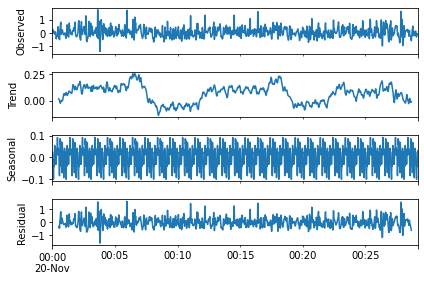

In [18]:
dc = sm.tsa.seasonal_decompose(sensor['userAcceleration.x'], freq=60)
plt.figure(figsize=(20,12))
dc.plot();

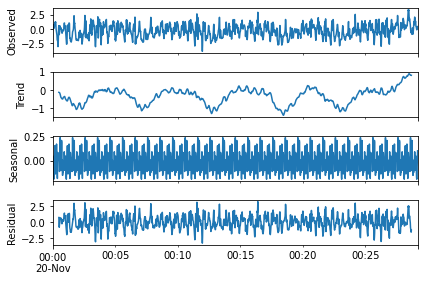

In [19]:
dc = sm.tsa.seasonal_decompose(sensor['rotationRate.x'], freq=60)
dc.plot();

# Modelamos los datos

Para modelar nuestros datos, debemos realizar hipótesis. Lo primero es detectar 
los valores residuales para detectar auto-correlación.

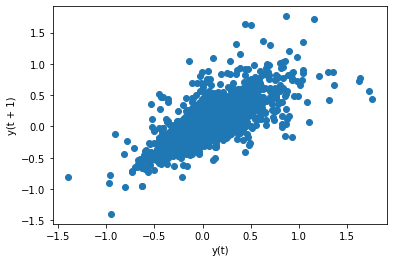

In [20]:
pd.plotting.lag_plot(sensor['userAcceleration.x']);

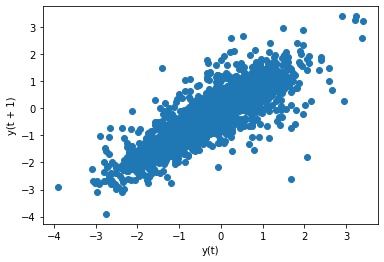

In [21]:
pd.plotting.lag_plot(sensor['rotationRate.x']);

Podemos asumir que ambos atributos tenga auto-correlación, sin embargo aplicamos el estudio estadístico de Augmented Dickey Fuller test

In [22]:
adf_acc = sm.tsa.stattools.adfuller(sensor['userAcceleration.x'])
adf_rot = sm.tsa.stattools.adfuller(sensor['rotationRate.x'])
print('p-valor adf_acceleration: {}'.format(adf_acc[1]))
print('p-valor adf_rotation: {}'.format(adf_rot[1]))

p-valor adf_acceleration: 2.823439483037483e-30
p-valor adf_rotation: 6.320230335912189e-06


In [23]:
# Para comprobar los valores de adf_acc y adf_rot
adf_acc

(-17.95799408616976,
 2.823439483037483e-30,
 4,
 1746,
 {'1%': -3.434100824760071,
  '10%': -2.5676520210882936,
  '5%': -2.863196780129223},
 -727.6140124402791)

In [24]:
adf_rot

(-5.269860625086421,
 6.320230335912189e-06,
 25,
 1725,
 {'1%': -3.4341465551936534,
  '10%': -2.567662770090317,
  '5%': -2.863216966926812},
 2619.6049719981947)

La conclusión es que podemos rechazar la hipótesis nula y concluir que ambas
variables son estacionarias.

Finalmente creamos un modelo ARMA utilizando la variable acceleration.x, ya que rechazando la hipótesis nula no debemos calcular el diferencial.

In [25]:
train, test = sensor['userAcceleration.x'][:-10], sensor['userAcceleration.x'][-10:]
arma = smt.arima_model.ARMA(train, order=(2,1)).fit()
prediccion = arma.predict(start=test.index[0], end=test.index[-1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


In [26]:
# Aplicamos la comparativa del valor predicho y su error
comparacion = pd.DataFrame(test)
comparacion.columns = ['Real']
comparacion['Predicho'] = prediccion
error_mtr = (comparacion.Real-comparacion.Predicho)*(comparacion.Real-comparacion.Predicho)
comparacion['Metrica error'] = error_mtr
display(comparacion)

,Real,Predicho,Metrica error
2021-11-20 00:29:01,0.149749,0.173149,0.000548
2021-11-20 00:29:02,0.038461,0.142896,0.010907
2021-11-20 00:29:03,-0.169175,0.100522,0.072736
2021-11-20 00:29:04,-0.300361,0.070106,0.137246
2021-11-20 00:29:05,-0.270174,0.056099,0.106454
2021-11-20 00:29:06,-0.268367,0.053778,0.103777
2021-11-20 00:29:07,-0.102444,0.056790,0.025356
2021-11-20 00:29:08,-0.085590,0.060646,0.021385
2021-11-20 00:29:09,-0.048105,0.063316,0.012415
2021-11-20 00:29:10,-0.065011,0.064493,0.016771


In [27]:
# Calculamos el RMSE
rmse = sm.tools.eval_measures.rmse(comparacion.Real, comparacion.Predicho, axis=0)
print('RMSE: {}'.format(rmse))

RMSE: 0.22529863971115618
